In [43]:
import pandas as pd
from biokit.viz import corrplot
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from numba import jit
import time

# 数据的导入

In [44]:
df=pd.read_csv('./data/statex77.csv')
df.set_index('Unnamed: 0',inplace=True)

In [45]:
df.corr()

,Population,Income,Illiteracy,Life Exp,Murder,HS Grad,Frost,Area
Population,1.000000,0.208228,0.107622,-0.068052,0.343643,-0.098490,-0.332152,0.022544
Income,0.208228,1.000000,-0.437075,0.340255,-0.230078,0.619932,0.226282,0.363315
Illiteracy,0.107622,-0.437075,1.000000,-0.588478,0.702975,-0.657189,-0.671947,0.077261
Life Exp,-0.068052,0.340255,-0.588478,1.000000,-0.780846,0.582216,0.262068,-0.107332
Murder,0.343643,-0.230078,0.702975,-0.780846,1.000000,-0.487971,-0.538883,0.228390
HS Grad,-0.098490,0.619932,-0.657189,0.582216,-0.487971,1.000000,0.366780,0.333542
Frost,-0.332152,0.226282,-0.671947,0.262068,-0.538883,0.366780,1.000000,0.059229
Area,0.022544,0.363315,0.077261,-0.107332,0.228390,0.333542,0.059229,1.000000


### 1.1 可视化相关系数

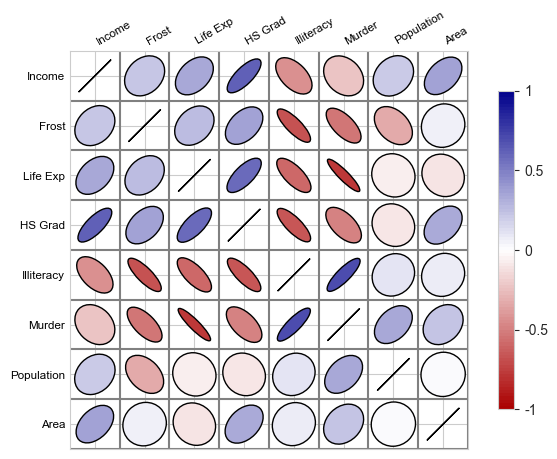

In [46]:
corrplot.Corrplot(df.corr()).plot()
plt.show()

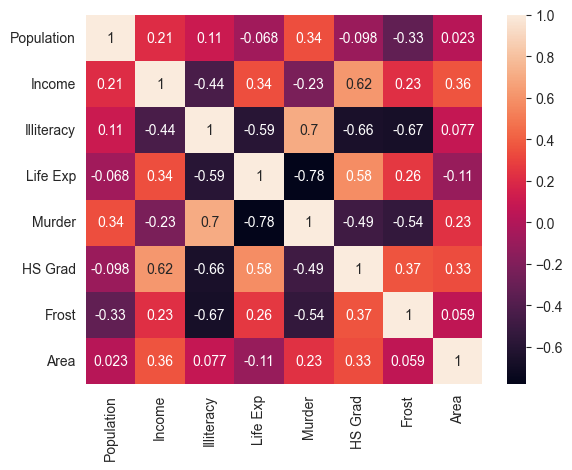

In [47]:
sns.heatmap(df.corr(),annot=True)#annot显示图中数字
plt.show()

### 1.2相关性检验
检验murder 和 forst是否相关

In [48]:
corr_1=df.corr()['Murder']['Frost']
corr_1#相关系数

-0.5388834366717312

分别是 检验统计量，相关系数，t_48分布的分位数

In [49]:
num_sample=len(df.iloc[:,0])
T=np.sqrt(num_sample-2)*corr_1/np.sqrt(1-corr_1**2)
T,stats.pearsonr(df['Murder'],df['Frost']),[stats.t.ppf(0.025,num_sample-2),stats.t.ppf(1-0.025,num_sample-2)]

(-4.432076317156236,
 PearsonRResult(statistic=-0.538883436671731, pvalue=5.4048398854074675e-05),
 [-2.010634754696446, 2.0106347546964454])

大样本检验

In [50]:
T=np.sqrt(num_sample-2)*corr_1
p_value=(1-stats.norm.cdf(np.abs(T)))*2
p_value,T

(0.00018884171948796435, -3.733493966691056)

### 1.3置换检验 
检验"Frost"和"Murder"是否独立

用numba加速置换检验的计算

In [51]:
@jit(nopython=True)
def permutation_test(X, Y, N):
    r_0 = np.abs(np.cov(X, Y)[0, 1])
    # 预分配numpy数组内存
    temp_A = np.empty(N, dtype=np.float64)
    for i in range(N):
        temp_A[i] = np.abs(np.cov(np.random.permutation(X), Y)[0, 1])
    return np.sum(temp_A >= r_0) / N

In [52]:
N=1000000
X,Y=np.array(df['Frost']),np.array(df['Murder'])

In [53]:
%time print(f'{N:.1e}次置换检验的p值为:   {permutation_test(X,Y,N):.4e}')

1.0e+06次置换检验的p值为:   5.9000e-05
CPU times: total: 5.86 s
Wall time: 6.21 s


# 练习1
练习 1. 我们可随机产生数据，检查 t-检验（函数 cor.test）与置换检验的结果（p 值）几乎相同。

In [54]:
n=20
np.random.seed(0)
X=np.random.randn(20)
np.random.seed(1)
Y=np.random.randn(20)
r_0=np.abs(np.cov(X,Y)[0,1])
N=100000

In [55]:
_,p_value_0=stats.pearsonr(X,Y)
print(f'精确检验和置换检验的p值分别为:{p_value_0:.4e},{permutation_test(X,Y,N):.4e}')

精确检验和置换检验的p值分别为:4.6824e-01,4.6742e-01


### 1.4非参数检验

In [56]:
X=np.array([2,-2,-11,3,4])
Y=np.array([0,-1,-3,99,7])
rankX=stats.rankdata(X)
rankY=stats.rankdata(Y)

In [57]:
pearson=np.cov(X,Y)[0,1]/(np.sqrt(np.cov(X,Y)[0,0]*np.cov(X,Y)[1,1]))
spearman=np.cov(rankX,rankY)[0,1]/np.sqrt(np.cov(rankX,rankY)[0,0]*np.cov(rankX,rankY)[1,1])
rankX=rankX-rankX.mean()
rankY=rankY-rankY.mean()
_,p_value=stats.pearsonr(rankX,rankY)
print(f'以下是spearman和pearson方法的调包')
[pearson,spearman],p_value,stats.spearmanr(X,Y),stats.pearsonr(rankX,rankY)

以下是spearman和pearson方法的调包


([0.4077189765413095, 0.9],
 0.037386073468498676,
 SignificanceResult(statistic=0.8999999999999998, pvalue=0.03738607346849874),
 PearsonRResult(statistic=0.8999999999999999, pvalue=0.037386073468498676))

In [58]:
#计算精确的p_value
X=stats.rankdata(X)
Y=stats.rankdata(Y)
def centered_inner_product(X,Y):
    return (X*Y).sum()-(X.sum()*Y.sum())/len(X)
def calculate_rho(X,Y):
    return centered_inner_product(X,Y)/np.sqrt(centered_inner_product(X,X)*centered_inner_product(Y,Y))
def calculate_T(r,N):
    return np.sqrt(N-2)*r/np.sqrt(1-r**2)
print(f'手动求解精确检验的p-value为: {(1-stats.t.cdf(calculate_T(calculate_rho(X,Y),len(X)),df=3))*2:.4e}')

手动求解精确检验的p-value为: 3.7386e-02


# 练习2
练习 2. 上述例子中 Spearman 检验的精确 p 值为 0.08333，它是基于 spearman 系数的原假设下的精确
分布计算得到的，该精确 p 值可用置换检验方法逼近。试分别进行 1000，10000，100000 次置换，按照
公式 (1) 分别计算置换检验 p 值，观察这些 p 值是否接近 0.08333。

用jit加速,用time计算时间

In [59]:
X=stats.rankdata(np.array([2,-2,-11,3,4]))
Y=stats.rankdata(np.array([0,-1,-3,99,7]))

In [60]:
for N in [1000,10000,100000,1000000]:
    %time print(f'{N:1.0e}   次置换检验的p值为:       {permutation_test(X,Y,N):.4e}')

1e+03   次置换检验的p值为:       8.9000e-02
CPU times: total: 0 ns
Wall time: 4 ms
1e+04   次置换检验的p值为:       7.9400e-02
CPU times: total: 31.2 ms
Wall time: 28 ms
1e+05   次置换检验的p值为:       8.4480e-02
CPU times: total: 234 ms
Wall time: 229 ms
1e+06   次置换检验的p值为:       8.3359e-02
CPU times: total: 2.56 s
Wall time: 2.61 s


# 2偏相关系数

### 2.1计算及检验

### 2.2偏相关系数矩阵计算

In [61]:
def partial_corr(corr_mat):
    inverse_corr=np.linalg.inv(corr_mat)
    diag=np.sqrt(np.diag(np.diag(1/inverse_corr)))
    partial_corr_mat=2*np.identity(len(corr_mat))-np.dot(diag,np.dot(inverse_corr,diag))
    return partial_corr_mat
df=pd.read_csv('./data/statex77.csv')
df.set_index('Unnamed: 0',inplace=True)
partial_corr(df.corr())

array([[ 1.        ,  0.32300027, -0.26148742,  0.26412823,  0.40899056,
        -0.24492979, -0.22139493, -0.05966557],
       [ 0.32300027,  1.        , -0.09587116, -0.01376349, -0.04286866,
         0.34074103,  0.0143403 ,  0.24354899],
       [-0.26148742, -0.09587116,  1.        ,  0.0142461 ,  0.24672522,
        -0.47770796, -0.56010767,  0.33078309],
       [ 0.26412823, -0.01376349,  0.0142461 ,  1.        , -0.70591759,
         0.30797597, -0.271     , -0.00682919],
       [ 0.40899056, -0.04286866,  0.24672522, -0.70591759,  1.        ,
         0.08682678, -0.25970424,  0.23544872],
       [-0.24492979,  0.34074103, -0.47770796,  0.30797597,  0.08682678,
         1.        , -0.17991875,  0.42343271],
       [-0.22139493,  0.0143403 , -0.56010767, -0.271     , -0.25970424,
        -0.17991875,  1.        ,  0.28014952],
       [-0.05966557,  0.24354899,  0.33078309, -0.00682919,  0.23544872,
         0.42343271,  0.28014952,  1.        ]])

# 3典则相关系数和决定系数

In [62]:
def classical_corr(Axx,Ayx,Ayy):
    #cholesky
    Ayy_sqrt=np.linalg.cholesky(Ayy)
    phi=np.dot(np.linalg.inv(Ayy_sqrt),np.dot(Ayx,np.dot(np.linalg.inv(Axx),np.dot(Ayx.T,np.linalg.inv(Ayy_sqrt)))))
    # 返回phi的最大特征值
    return np.max(np.linalg.eigvals(phi))

In [63]:
def decision_coefficient(Axx,Ayx,Ayy):
    #phi=Ayx*Axx^-1*Ayx^T/Ayy
    phi=np.dot(Ayx,np.dot(np.linalg.inv(Axx),Ayx.T))/Ayy
    #输出phi的内容
    return np.array(phi).__float__()

# 练习3


数据载入

In [64]:
df_1=pd.read_csv('./data/Ability_cov.csv')
df_1.set_index('Unnamed: 0',inplace=True)
df_1.drop('center',axis=1,inplace=True)
df_1.drop('n.obs',axis=1,inplace=True)
df_1

,cov.general,cov.picture,cov.blocks,cov.maze,cov.reading,cov.vocab
Unnamed: 0,,,,,,
general,24.641,5.991,33.520,6.023,20.755,29.701
picture,5.991,6.700,18.137,1.782,4.936,7.204
blocks,33.520,18.137,149.831,19.424,31.430,50.753
maze,6.023,1.782,19.424,12.711,4.757,9.075
reading,20.755,4.936,31.430,4.757,52.604,66.762
vocab,29.701,7.204,50.753,9.075,66.762,135.292


R 数据集 ability.cov 给出了 112 个儿童的 6 项测试成绩的协方差矩阵，6 个科目分别是 general,
picture, blocks , maze, reading, vocab （综、绘画、积木、迷宫、阅读、词汇量）。
(a) 求 picture 与 reading 的偏相关系数
(b) 求 general 与其余 5 个变量 (picture, blocks , maze, reading, vocab) 之间的相关性大小 (决定系数）
(c) 求 (picture, blocks , maze）与（reading, vocab) 之间的相关性大小（第一典则相关系数）。

In [65]:
# a 求 picture 与 reading 的偏相关系数
partial_corr(df_1)[4,1]

-0.0073933799183709984

In [66]:
# b 求 general 与其余 5 个变量 (picture, blocks , maze, reading, vocab) 之间的相关性大小 (决定系数）
decision_coefficient(df_1.iloc[1:6,1:6],df_1.iloc[0:1,1:6],df_1.iloc[0:1,0:1])

0.5066464686282858

In [67]:
#c 求 (picture, blocks , maze）与（reading, vocab) 之间的相关性大小（第一典则相关系数）。 
classical_corr(df_1.iloc[1:4,1:4],df_1.iloc[4:6,1:4],df_1.iloc[4:6,4:6])

-0.016841391008159734